In [5]:
# Copy from Y1-shear-cluster-demo; but after getting the Fisher(Covariance) we use cobaya...just for testing

import sys
sys.path.append('/Users/kunhao/Dropbox/code/projects/jax_late_mod/jax_cosmo_late_mod')
from jax.config import config
config.update("jax_enable_x64", True)

In [6]:
%pylab inline
import os.path
import jax
import jax.numpy as np
import jax_cosmo as jc

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/kunhao/miniconda3/envs/py38/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Exercice: WL + Galaxy-Clustering $C_\ell$

# Retrieving the nz data

In [7]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

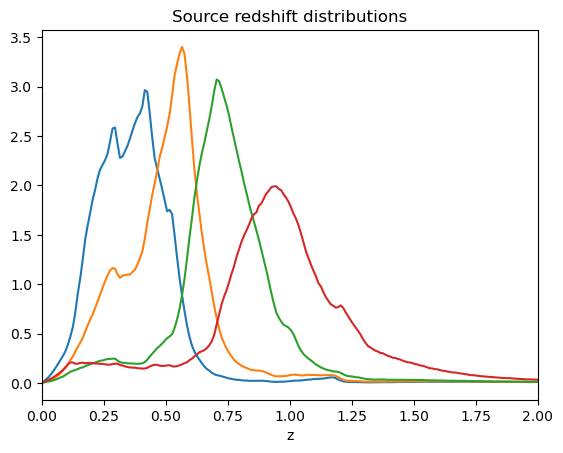

In [8]:
# Let's plot the NZs
plot(nz_source['Z_MID'], nz_source['BIN1'])
plot(nz_source['Z_MID'], nz_source['BIN2'])
plot(nz_source['Z_MID'], nz_source['BIN3'])
plot(nz_source['Z_MID'], nz_source['BIN4'])
xlim(0,2);
xlabel('z')
title('Source redshift distributions');

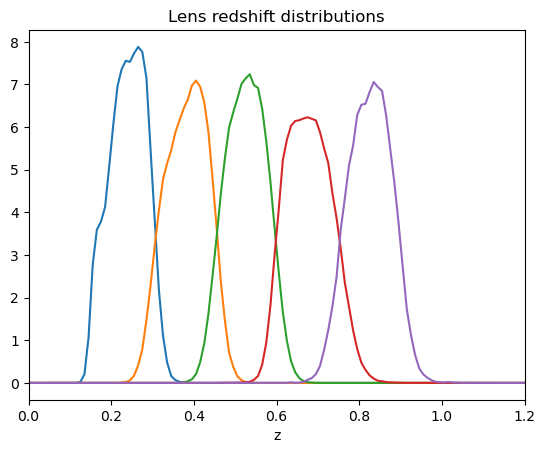

In [9]:
# Let's plot the NZs
plot(nz_lens['Z_MID'], nz_lens['BIN1'])
plot(nz_lens['Z_MID'], nz_lens['BIN2'])
plot(nz_lens['Z_MID'], nz_lens['BIN3'])
plot(nz_lens['Z_MID'], nz_lens['BIN4'])
plot(nz_lens['Z_MID'], nz_lens['BIN5'])
xlim(0,1.2);
xlabel('z')
title('Lens redshift distributions');

In [10]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1], zmax=2)
           for i in range(1,5)]

Text(0.5, 1.0, 'Source redshift distributions')

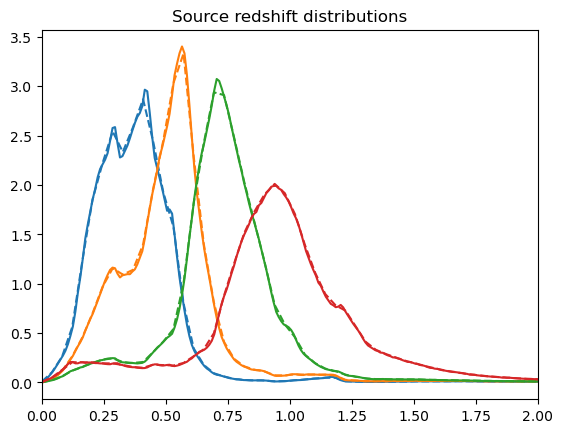

In [11]:
z = linspace(0,2)
for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2);
title('Source redshift distributions')

In [12]:
nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                            nz_lens['BIN%d'%i].astype('float32'), bw=0.01, zmax=1)
        for i in range(1,6)]    

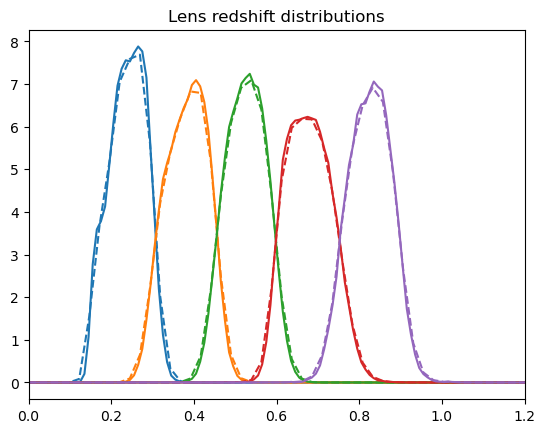

In [13]:
z = linspace(0,1.2)
#fig,axs=plt.subplots(1,5,figsize=(15,5))
for i in range(5):
    plot(nz_lens['Z_MID'], nz_lens['BIN%d'%(i+1)], color='C%d'%i, label=f'FITS BIN[{i}]')
    plot(z, nzs_l[i](z), '--', color='C%d'%i, label='jc kde')
    xlim(0,1.2);
#legend()
title('Lens redshift distributions');

# Let's build a model for C_ell

In [14]:
def get_params_vec(cosmo, m, dz, ia, bias):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    b1, b2, b3, b4, b5 = bias
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta,
        # linear galaxy bias
        b1, b2, b3, b4, b5
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    bias = params[16:21]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta], bias



# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.], [1.,2.,3.,4.,5.])
print(unpack_params_vec(p))

(Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159, [Array(1., dtype=float64), Array(2., dtype=float64), Array(3., dtype=float64), Array(4., dtype=float64)], [Array(5., dtype=float64), Array(6., dtype=float64), Array(7., dtype=float64), Array(8., dtype=float64)], [Array(1., dtype=float64), Array(2., dtype=float64)], Array([1., 2., 3., 4., 5.], dtype=float64))


In [15]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi, zmax=2.0) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)

    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 

    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]

    
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl, probes

In [16]:
print("le nombre de ell:",ell.shape)

le nombre de ell: (50,)


In [17]:
#f_sky = 1321./41253.
f_sky = 0.25
print("f_sky", f_sky)

@jax.jit
def cov(params):
    
    cl_signal, probes = mu(params)
        
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)
    
    return cov

f_sky 0.25


In [18]:
def cl_mean(p):
    cl,_ = mu(p)
    return cl.flatten()
jacobian = jax.jit(jax.jacfwd(lambda p: cl_mean(p)))

In [19]:
# Let's try it out
from functools import partial

FiducialCosmo = partial(jc.Cosmology, sigma8=0.801,
                         Omega_c=0.2545,
                         Omega_b=0.0485,
                         h=0.682,
                         n_s=0.971,
                         w0=-1., Omega_k=0., wa=0.)

fid_cosmo = FiducialCosmo()

fid_params = get_params_vec(fid_cosmo, 
                            [0., 0., 0., 0.],
                            [0., 0., 0., 0.],
                            [0.5, 0.],
                            [1.2, 1.4, 1.6, 1.8, 2.0])

In [20]:
unpack_params_vec(fid_params )

(Cosmological parameters: 
     h:        0.682 
     Omega_b:  0.0485 
     Omega_c:  0.2545 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.971 
     sigma8:   0.801,
 [Array(0., dtype=float64),
  Array(0., dtype=float64),
  Array(0., dtype=float64),
  Array(0., dtype=float64)],
 [Array(0., dtype=float64),
  Array(0., dtype=float64),
  Array(0., dtype=float64),
  Array(0., dtype=float64)],
 [Array(0.5, dtype=float64), Array(0., dtype=float64)],
 Array([1.2, 1.4, 1.6, 1.8, 2. ], dtype=float64))

In [21]:
cl_wlnc,_ = mu(fid_params)

In [22]:
cl_wlnc.shape

(45, 50)

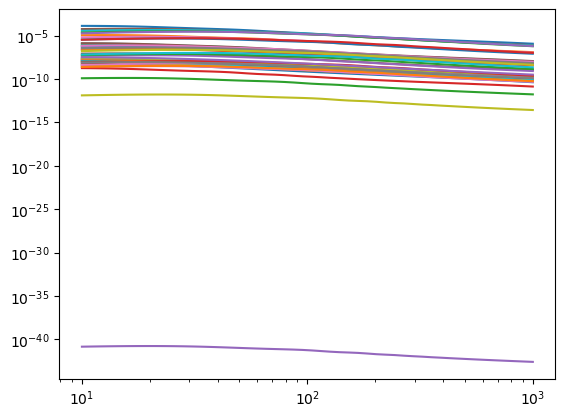

In [23]:
for i in range(cl_wlnc.shape[0]):
    loglog(ell, cl_wlnc[i])

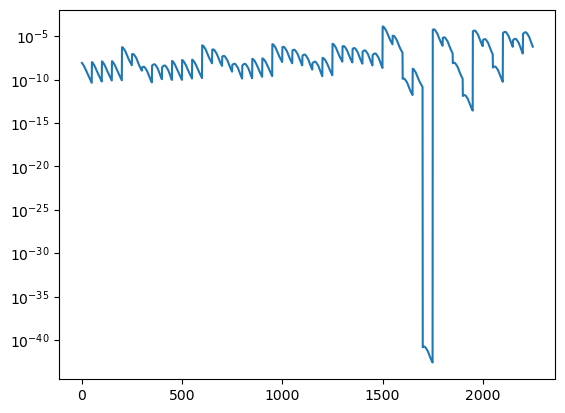

In [24]:
semilogy(cl_wlnc.flatten())

In [25]:
#np.save('JEC_desy1_mock_data.npy',cl_wlnc.flatten())

In [26]:
#data = np.load('JEC_desy1_mock_data.npy')

In [27]:
C = cov(fid_params)

In [28]:
C.shape

(2250, 2250)

In [29]:
j = jacobian(fid_params)

In [30]:
j.shape

(2250, 21)

In [31]:
# And we get the fisher matrix from the jacobian and covariance
F = np.einsum('ia,ij,jb',j,np.linalg.inv(C),j)
F = 0.5*(F+F.T)

# Add priors to systematics
import numpy as onp
d = onp.zeros(j.shape[1])
d[6] = 1./(2.3e-2)**2
d[7] = 1./(2.3e-2)**2
d[8] = 1./(2.3e-2)**2
d[9] = 1./(2.3e-2)**2
d[10] = 1./(1.6e-2)**2
d[11] = 1./(1.3e-2)**2
d[12] = 1./(1.1e-2)**2
d[13] = 1./(2.2e-2)**2

F = F + np.diag(d)

In [39]:
F.shape, fid_params.shape

((21, 21), (21,))

In [70]:
np.sqrt(np.diag(Cov_param))

Array([0.01189658, 0.0107761 , 0.00574935, 0.03844666, 0.0135104 ,
       0.07105699, 0.02094256, 0.01736488, 0.01475428, 0.01457845,
       0.01013535, 0.00656971, 0.00589691, 0.00860384, 0.05206308,
       1.08953074, 0.01571036, 0.01881371, 0.02244708, 0.02616233,
       0.02979189], dtype=float64)

In [92]:
#TEST with cobaya sampler
from cobaya.run import run
import numpy

Cov_param  = np.array(np.linalg.inv(F))
fid_params = np.array(numpy.array(fid_params))
params_names = ["Omega_c", "sigma8", "Omega_b", "h", "ns", "w0", "A", "eta", "m1",
                               "m2", "m3", "m4", "dz1", "dz2", "dz3", "dz4", "b1", "b2","b3","b4","b5"]

info = {
    "likelihood": {
        "gaussian_mixture": {
            "means": fid_params,
            "covs": Cov_param,
            "derived": False}},
    "params": dict([
        ("Omega_c", {
            "prior": {"min": 0.1, "max": 0.9},
            "latex": r"\Omega_c",
            "proposal": 0.3,}),
        ("sigma8", {
            "prior": {"min": 0.4, "max": 1.0},
            "latex": r"\sigma_8",
            "proposal": 0.8,}),
        ("Omega_b", {
            "prior": {"min": 0.03, "max": 0.07},
            "latex": r"\Omega_b",
            "proposal": 0.04,}),
        ("h", {
            "prior": {"min": 0.55, "max": 0.91},
            "latex": r"h",
            "proposal": 0.7,}),
        
        ("ns", {
            "prior": {"min": 0.87, "max": 1.07},
            "latex": r"ns"}),
        ("w0", {
            "prior": {"min": -2.0, "max": -0.33},
            "latex": r"w0"}),    
        ("A", {
            "prior": {"min": -5.0, "max": +5.0},
            "latex": r"A"}),    
        ("eta", {
            "prior": {"min": -5.0, "max": +5.0},
            "latex": r"eta"}),    
        ("m1", {
            "prior": {"dist": "norm", "loc": 0.012, "scale": 0.012},
            "latex": r"m1"}),   
        ("m2", {
            "prior": {"dist": "norm", "loc": 0.012, "scale": 0.012},
            "latex": r"m2"}),   
        ("m3", {
            "prior": {"dist": "norm", "loc": 0.012, "scale": 0.012},
            "latex": r"m3"}),   
        ("m4", {
            "prior": {"dist": "norm", "loc": 0.012, "scale": 0.012},
            "latex": r"m4"}),   
        ("dz1", {
            "prior": {"dist": "norm", "loc": 0.001, "scale": 0.016},
            "latex": r"dz1"}),  
        ("dz2", {
            "prior": {"dist": "norm", "loc": -0.019, "scale": 0.013},
            "latex": r"dz2"}),  
        ("dz3", {
            "prior": {"dist": "norm", "loc": 0.009, "scale": 0.011},
            "latex": r"dz3"}),  
        ("dz4", {
            "prior": {"dist": "norm", "loc": -0.018, "scale": 0.022},
            "latex": r"dz4"}),  
        ("b1", {
            "prior": {"min": 0.8, "max": 3.0},
            "latex": r"b1"}),  
        ("b2", {
            "prior": {"min": 0.8, "max": 3.0},
            "latex": r"b2"}),  
        ("b3", {
            "prior": {"min": 0.8, "max": 3.0},
            "latex": r"b3"}),  
        ("b4", {
            "prior": {"min": 0.8, "max": 3.0},
            "latex": r"b4"}),  
        ("b5", {
            "prior": {"min": 0.8, "max": 3.0},
            "latex": r"b5"}),  
    ]),
    "sampler": {
        "mcmc":{
            "max_tries": "200d"
#             "covmat": Cov_param},
#             "covmat_params": params_names
        }
    }
}

In [93]:
updated_info, sampler = run(info)

[prior] *WARNING* There are unbounded parameters (['m1', 'm2', 'm3', 'm4', 'dz1', 'dz2', 'dz3', 'dz4']). Prior bounds are given at 0.9999995 confidence level. Beware of likelihood modes at the edge of the prior
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {gaussian_mixture: 23600.0}
[mcmc] Initial point: Omega_c:0.8609613, sigma8:0.8115112, Omega_b:0.05250148, h:0.7789155, ns:0.9046752, w0:-1.664355, A:-2.26632, eta:-0.8034505, m1:0.007309406, m2:0.01130275, m3:0.0135829, m4:0.008011887, dz1:-0.01777254, dz2:-0.01800398, dz3:0.007025957, dz4:0.01136067, b1:1.605756, b2:1.654699, b3:2.812315, b4:1.924658, b5:2.942743
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance

LoggedError: The chain has been stuck for 4200 attempts, stopping sampling. Make sure the reference point is sensible and initial covmat. For parameters not included in an initial covmat, the 'proposal' width set for each parameter should be of order of the expected conditional posterior width, which may be much smaller than the marginalized posterior width - choose a smaller rather than larger value if in doubt. You can also decrease the 'proposal_scale' option for mcmc, though small values will sample less efficiently once things converge. Or make your starting 'ref'tighter around an expected best-fit value
Alternatively (though not advisable) make 'max_tries: np.inf' (or 'max_tries: .inf' in yaml).
Current point: Omega_c:0.6343442, sigma8:0.4000557, Omega_b:0.03006813, h:0.5500229, ns:0.9129713, w0:-1.382637, A:-0.1948922, eta:-0.1226241, m1:-0.004631276, m2:0.01036566, m3:0.02373189, m4:0.009935125, dz1:-0.02594245, dz2:-0.02846823, dz3:-1.814608e-05, dz4:0.002598572, b1:1.658665, b2:1.93442, b3:2.190811, b4:2.428497, b5:2.673041
Current result: LogPosterior(logpost=-1494.0221551368563, logpriors=[20.748301740060217], loglikes=array([-1514.77045688]), derived=[], finite=False)
Last proposal: [ 7.55200041e-01  4.73236526e-01  3.64329860e-02  6.87384540e-01
  8.97428203e-01 -1.37334016e+00 -6.18397292e-01 -8.43407476e-02
 -5.92808780e-03  1.09343538e-02  2.61221068e-02  7.63570376e-03
 -2.97850061e-02 -2.96081859e-02  4.88779073e-04 -7.93297235e-04
  1.58612917e+00  2.06306150e+00  2.28088368e+00  2.38587618e+00
  2.58987311e+00]
With rejected result: LogPosterior(logpost=-75356.72335157082, logpriors=[20.00034937371342], loglikes=array([-75376.72370094]), derived=[], finite=False)

In [ ]:
gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])
# Analyze and plot
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["a", "b"], filled=True)